# Setup dependencies / Set up GPU acceleration

In [3]:
import tensorflow as tf
import os

In [4]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [5]:
#!pip list # used to make sure correct version of tensorflow is installed for gpu acceleration

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')

In [7]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 1.0 Load and Visualize Data

# 1.1 import flower dataset

In [234]:
from tensorflow import keras

In [235]:
path_train = "Datasets/Flower_dataset/train"

In [236]:
os.listdir(path_train)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [237]:
data = tf.keras.utils.image_dataset_from_directory(path_train,image_size = (128,128),batch_size = 32)

Found 2747 files belonging to 5 classes.


In [238]:
data_iterator = data.as_numpy_iterator()

In [239]:
batch = data_iterator.next()

In [240]:
labels_list = sorted(os.listdir(path_train))
label_dictionary = {labels_list[i]:i for i in range(len(labels_list))}
label_dictionary

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

# 1.2 Visualize data using matplotlib

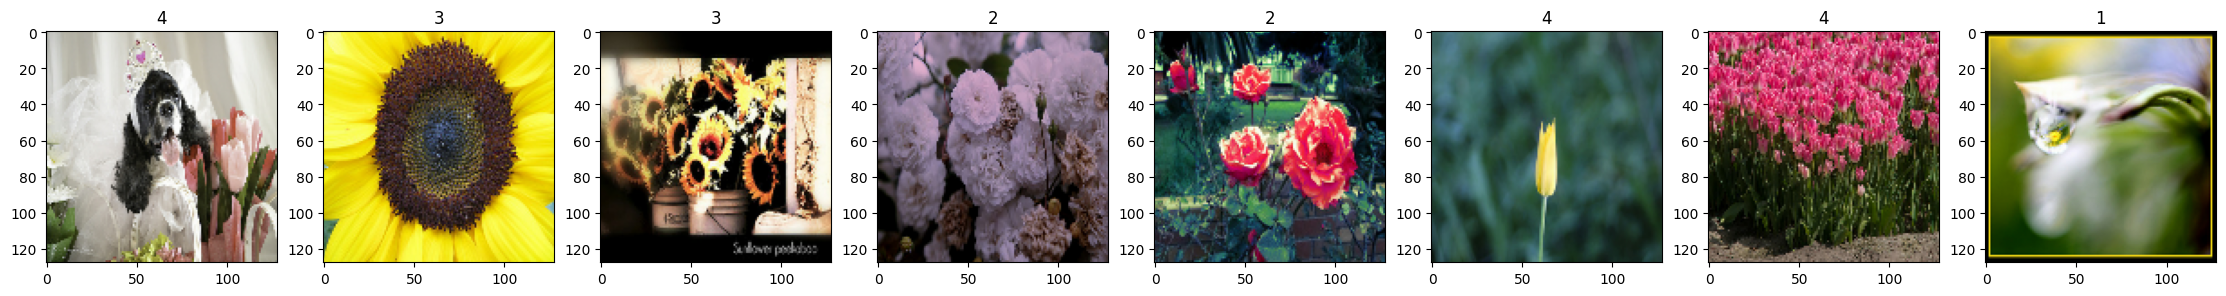

In [241]:
fig,ax = plt.subplots(ncols = 8, figsize = (28,28))
rows = 0
for idx,img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 1.3 Apply normalization --> all pixels between 0 - 1

In [242]:
data = data.map(lambda x,y: (x/255,y))

In [243]:
data_iterator = data.as_numpy_iterator()

In [244]:
batch = data_iterator.next()
batch[0].shape

(32, 128, 128, 3)

# 1.4 Create train/test/val data 

### train size ~ 2240 images
### val size ~ 256 images
### test size ~ 256 images

In [245]:
len(data)

86

In [246]:
train_size = int(len(data) * .8) + 2
print(train_size)
val_size = int(len(data) * .10)
print(val_size)
test_size = int(len(data) * .10)
print(test_size)

70
8
8


In [247]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

# 2 Build CNN model

In [248]:
from tensorflow.keras.models import Sequential

In [249]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, BatchNormalization, ReLU, Dropout

In [250]:
from tensorflow.keras.regularizers import l2

In [251]:
def Model():
    model = Sequential()

    # First Layer
    model.add(Conv2D(32,(2,2),1,activation = "relu",padding = "same",input_shape = (128,128,3),kernel_regularizer = l2(0.001)))
    model.add(MaxPooling2D())

    # Second Layer
    model.add(Conv2D(64,(2,2),1,activation = "relu",padding = "same"))
    model.add(MaxPooling2D())

    #Third layer
    model.add(Conv2D(128,(2,2),1,activation = "relu",padding = "same",kernel_regularizer = l2(0.001)))
    model.add(MaxPooling2D())
    
    # Fith Layer
    model.add(Flatten())
    model.add(Dense(128,activation = "relu",kernel_regularizer = l2(0.001)))
    model.add(Dropout(0.5))

    # Final layer
    model.add(Dense(5,activation = "softmax"))
    return model


In [252]:
model = Model()
model.compile('adam',loss = 'sparse_categorical_crossentropy',metrics=['accuracy'])

In [253]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 128, 128, 32)      416       
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 64, 64, 64)        8256      
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 32, 32, 128)       32896     
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 16, 16, 128)    

# 3 Train the model

In [29]:
results = 'results'

In [30]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=results)

In [31]:
hist = model.fit(train,epochs=20,validation_data=val, callbacks = [tensorboard_callback])

Epoch 1/20
70/70 [==============================] - 6s 21ms/step - loss: 1.6746 - accuracy: 0.3469 - val_loss: 1.4164 - val_accuracy: 0.4766
Epoch 2/20
70/70 [==============================] - 1s 18ms/step - loss: 1.3152 - accuracy: 0.5067 - val_loss: 1.1339 - val_accuracy: 0.5938
Epoch 3/20
70/70 [==============================] - 1s 18ms/step - loss: 1.2114 - accuracy: 0.5518 - val_loss: 1.1371 - val_accuracy: 0.6055
Epoch 4/20
70/70 [==============================] - 1s 19ms/step - loss: 1.1529 - accuracy: 0.5844 - val_loss: 1.0745 - val_accuracy: 0.6055
Epoch 5/20
70/70 [==============================] - 1s 18ms/step - loss: 1.0692 - accuracy: 0.6152 - val_loss: 1.0576 - val_accuracy: 0.6211
Epoch 6/20
70/70 [==============================] - 1s 18ms/step - loss: 1.0393 - accuracy: 0.6536 - val_loss: 1.0190 - val_accuracy: 0.6523
Epoch 7/20
70/70 [==============================] - 1s 18ms/step - loss: 0.9978 - accuracy: 0.6746 - val_loss: 0.9603 - val_accuracy: 0.7266
Epoch 8/20
70

# 3.1 Model evaulation

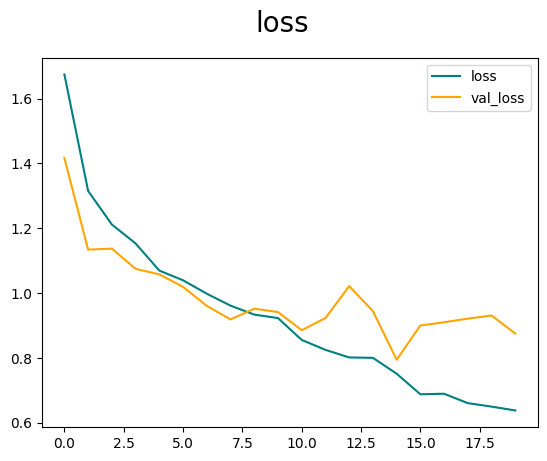

In [32]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label = "loss")
plt.plot(hist.history['val_loss'], color = 'orange', label = "val_loss")
fig.suptitle('loss', fontsize = 20)
plt.legend()
plt.show()

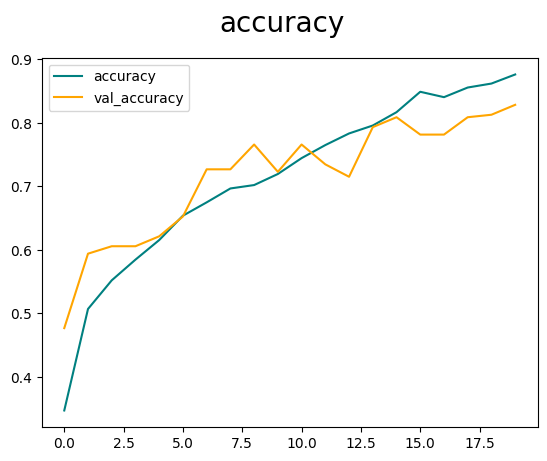

In [33]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'teal', label = "accuracy")
plt.plot(hist.history['val_accuracy'], color = 'orange', label = "val_accuracy")
fig.suptitle('accuracy', fontsize = 20)
plt.legend()
plt.show()

# 4 Test on test set

In [34]:
l = a = c = 0
for batch in test.as_numpy_iterator():
    X,y = batch
    loss,accuracy = model.evaluate(X,y)
    l += loss
    a += accuracy
    c += 1
    

1/1 [==============================] - 0s 77ms/step - loss: 1.0830 - accuracy: 0.7407


In [35]:
print("average loss = ",l / c)

average loss =  1.013708733022213


In [36]:
print("average accuracy = ",a / c)

average accuracy =  0.7996238395571709


# 5. Interpret results and save

In [37]:
model.save("CNN_model_of_184-1.h5")

# 6. Build MLP model 

In [286]:
def model_MLP():
    model = Sequential()
    
    model.add(Flatten(input_shape = (128,128,3)))
    model.add(Dense(128,activation = "ReLU",kernel_regularizer = l2(0.001)))
    model.add(Dropout(0.2))

    model.add(Dense(256,activation = "ReLU",kernel_regularizer = l2(0.001)))
    model.add(Dropout(0.2))

    model.add(Dense(5,activation = "softmax"))

    return model
    

    

In [287]:
MLP = model_MLP() 
MLP.compile('adam',loss = 'sparse_categorical_crossentropy',metrics=['accuracy'])

In [288]:
MLP.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_21 (Flatten)        (None, 49152)             0         
                                                                 
 dense_49 (Dense)            (None, 128)               6291584   
                                                                 
 dropout_28 (Dropout)        (None, 128)               0         
                                                                 
 dense_50 (Dense)            (None, 256)               33024     
                                                                 
 dropout_29 (Dropout)        (None, 256)               0         
                                                                 
 dense_51 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 6,325,893
Trainable params: 6,325,893
N

In [289]:
results_MLP = 'results_MLP'

In [290]:
tensorboard_callback_MLP = tf.keras.callbacks.TensorBoard(log_dir=results_MLP)

In [291]:
hist_MLP = model.fit(train,epochs=20,validation_data=val, callbacks = [tensorboard_callback_MLP])

Epoch 1/20
70/70 [==============================] - 2s 20ms/step - loss: 0.4019 - accuracy: 0.9571 - val_loss: 1.0488 - val_accuracy: 0.8438
Epoch 2/20
70/70 [==============================] - 1s 19ms/step - loss: 0.4019 - accuracy: 0.9558 - val_loss: 1.0103 - val_accuracy: 0.8438
Epoch 3/20
70/70 [==============================] - 1s 19ms/step - loss: 0.4143 - accuracy: 0.9545 - val_loss: 1.0072 - val_accuracy: 0.8320
Epoch 4/20
70/70 [==============================] - 1s 19ms/step - loss: 0.4041 - accuracy: 0.9531 - val_loss: 0.8897 - val_accuracy: 0.8672
Epoch 5/20
70/70 [==============================] - 1s 20ms/step - loss: 0.4023 - accuracy: 0.9585 - val_loss: 0.9850 - val_accuracy: 0.8516
Epoch 6/20
70/70 [==============================] - 1s 19ms/step - loss: 0.4281 - accuracy: 0.9509 - val_loss: 0.9342 - val_accuracy: 0.8750
Epoch 7/20
70/70 [==============================] - 1s 19ms/step - loss: 0.3745 - accuracy: 0.9661 - val_loss: 1.0015 - val_accuracy: 0.8516
Epoch 8/20
70

In [292]:
l = a = c = 0
for batch in test.as_numpy_iterator():
    X,y = batch
    loss,accuracy = model.evaluate(X,y)
    l += loss
    a += accuracy
    c += 1

1/1 [==============================] - 0s 25ms/step - loss: 0.4523 - accuracy: 0.9630


In [293]:
print("average loss = ",l / c)

average loss =  1.3720122538506985


In [294]:
print("average accuracy = ",a / c)

average accuracy =  0.7883391231298447


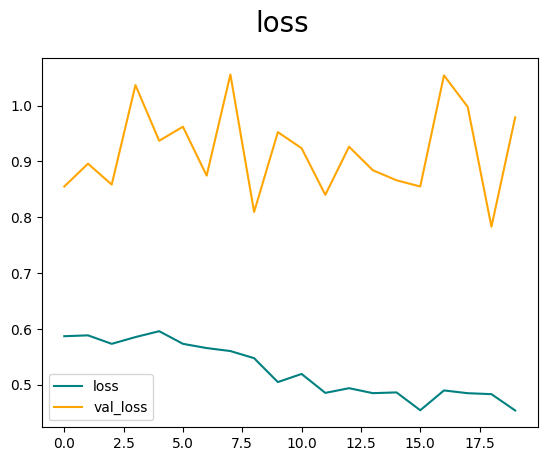

In [275]:
fig = plt.figure()
plt.plot(hist_MLP.history['loss'], color = 'teal', label = "loss")
plt.plot(hist_MLP.history['val_loss'], color = 'orange', label = "val_loss")
fig.suptitle('loss', fontsize = 20)
plt.legend()
plt.show()

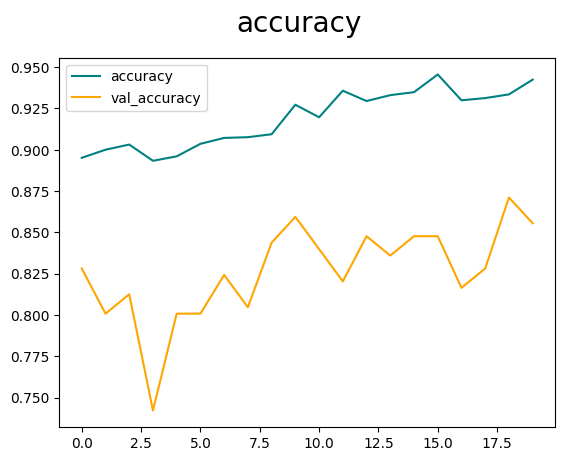

In [276]:
fig = plt.figure()
plt.plot(hist_MLP.history['accuracy'], color = 'teal', label = "accuracy")
plt.plot(hist_MLP.history['val_accuracy'], color = 'orange', label = "val_accuracy")
fig.suptitle('accuracy', fontsize = 20)
plt.legend()
plt.show()

In [86]:
MLP.save("MLP_model_of_184.h5")

# 7. Results:
## CNN: 79.9% accuracy    ----  MLP: 83% accuracy

# 8. New Dataset - Shark Image Classifier

## 8.1 Load in new dataset

In [318]:
path_data_train = "Datasets/Daisy_Dandelion/train"
path_data_val = "Datasets/Daisy_Dandelion/valid"
path_data_test = "Datasets/Daisy_Dandelion/test"

In [319]:
os.listdir(path_data_train)

['daisy', 'dandelion']

In [320]:
data_train = tf.keras.utils.image_dataset_from_directory(path_data_train,image_size = (128,128),batch_size = 32)
data_val = tf.keras.utils.image_dataset_from_directory(path_data_val,image_size = (128,128),batch_size = 32)
data_test = tf.keras.utils.image_dataset_from_directory(path_data_test,image_size = (128,128),batch_size = 32)

Found 1275 files belonging to 2 classes.
Found 364 files belonging to 2 classes.
Found 182 files belonging to 2 classes.


In [321]:
data_iterator_train = data_train.as_numpy_iterator()
data_iterator_val = data_val.as_numpy_iterator()
data_iterator_test = data_test.as_numpy_iterator()

In [322]:
batch = data_iterator_train.next()

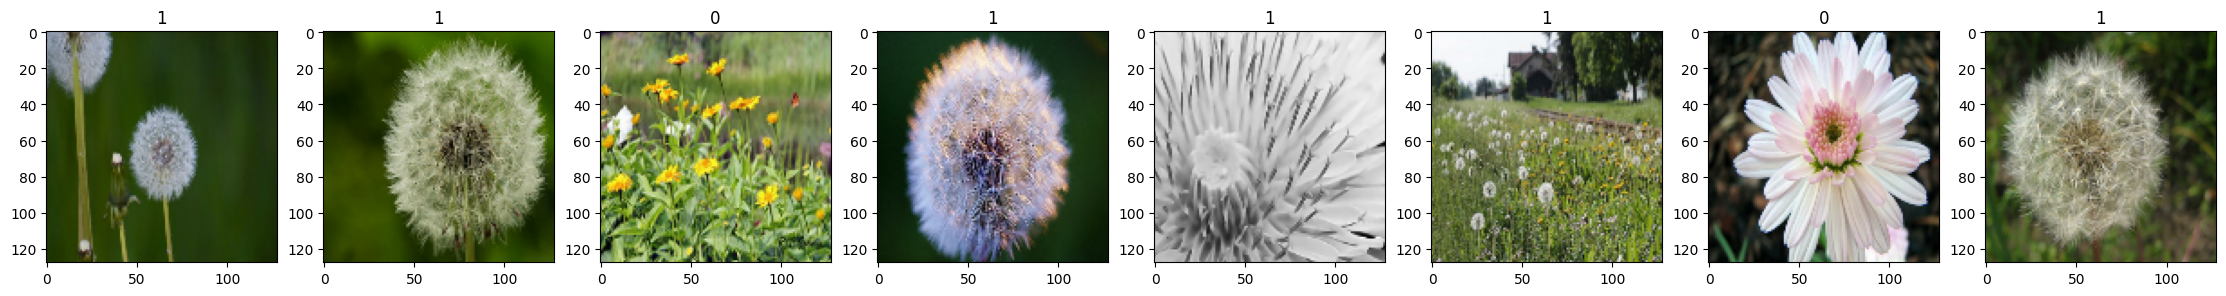

In [323]:
fig,ax = plt.subplots(ncols = 8, figsize = (28,28))
rows = 0
for idx,img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [324]:
labels_list = sorted(os.listdir(path_data_train))
label_dictionary = {labels_list[i]:i for i in range(len(labels_list))}
label_dictionary

{'daisy': 0, 'dandelion': 1}

In [325]:
data_train = data_train.map(lambda x,y: (x/255,y))
data_val = data_val.map(lambda x,y: (x/255,y))
data_test = data_test.map(lambda x,y: (x/255,y))

In [326]:
data_iterator_train = data_train.as_numpy_iterator()
data_iterator_val = data_val.as_numpy_iterator()
data_iterator_test = data_test.as_numpy_iterator()

In [327]:
batch_train = data_iterator_train.next()
batch_train[0].shape

(32, 128, 128, 3)

# 1.4 Create train/test/val data 

### train size ~ 1275  images
### val size ~ 364 images
### test size ~ 182 images

In [337]:
train_size = int(len(data_train))
print(train_size)
val_size = int(len(data_val))
print(val_size)
test_size = int(len(data_test))
print(test_size)

40
12
6


In [338]:
X = data_train.take(train_size)
V = data_val.take(val_size)
T = data_test.take(test_size)

In [339]:
def Model_2():
    model = Sequential()

    # First Layer
    model.add(Conv2D(32,(2,2),1,activation = "relu",padding = "same",input_shape = (128,128,3),kernel_regularizer = l2(0.001)))
    model.add(MaxPooling2D())

    # Second Layer
    model.add(Conv2D(64,(2,2),1,activation = "relu",padding = "same"))
    model.add(MaxPooling2D())

    #Third layer
    model.add(Conv2D(128,(2,2),1,activation = "relu",padding = "same",kernel_regularizer = l2(0.001)))
    model.add(MaxPooling2D())
    
    # Fith Layer
    model.add(Flatten())
    model.add(Dense(64,activation = "relu",kernel_regularizer = l2(0.001)))
    model.add(Dropout(0.5))

    # Final layer
    model.add(Dense(1,activation = "sigmoid"))
    return model


In [340]:
model_2 = Model_2()
model_2.compile('adam',loss = 'binary_crossentropy',metrics=['accuracy'])

In [341]:
model_2.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 128, 128, 32)      416       
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 64, 64, 64)        8256      
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 32, 32, 128)       32896     
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 16, 16, 128)    

In [342]:
results_m2 = 'results_m2'

In [343]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=results_m2)

In [344]:
X

<TakeDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [345]:
hist_m2 = model_2.fit(X,epochs=40,validation_data=V, callbacks = [tensorboard_callback])

Epoch 1/40
40/40 [==============================] - 1s 19ms/step - loss: 0.8393 - accuracy: 0.5835 - val_loss: 0.7111 - val_accuracy: 0.6236
Epoch 2/40
40/40 [==============================] - 1s 15ms/step - loss: 0.7094 - accuracy: 0.6635 - val_loss: 0.6274 - val_accuracy: 0.7390
Epoch 3/40
40/40 [==============================] - 1s 17ms/step - loss: 0.6127 - accuracy: 0.7427 - val_loss: 0.5762 - val_accuracy: 0.7500
Epoch 4/40
40/40 [==============================] - 1s 15ms/step - loss: 0.5545 - accuracy: 0.7859 - val_loss: 0.4837 - val_accuracy: 0.8159
Epoch 5/40
40/40 [==============================] - 1s 15ms/step - loss: 0.5091 - accuracy: 0.8125 - val_loss: 0.4779 - val_accuracy: 0.8379
Epoch 6/40
40/40 [==============================] - 1s 15ms/step - loss: 0.4955 - accuracy: 0.8180 - val_loss: 0.4555 - val_accuracy: 0.8324
Epoch 7/40
40/40 [==============================] - 1s 15ms/step - loss: 0.4765 - accuracy: 0.8361 - val_loss: 0.4499 - val_accuracy: 0.8214
Epoch 8/40
40

In [346]:
l = a = c = 0
for batch in T.as_numpy_iterator():
    train_x,y = batch
    loss,accuracy = model_2.evaluate(train_x,y)
    l += loss
    a += accuracy
    c += 1

1/1 [==============================] - 0s 21ms/step - loss: 0.7649 - accuracy: 0.8182


In [347]:
print("average loss = ",l / c)

average loss =  0.6497166852156321


In [348]:
print("average accuracy = ",a / c)

average accuracy =  0.8342803021272024


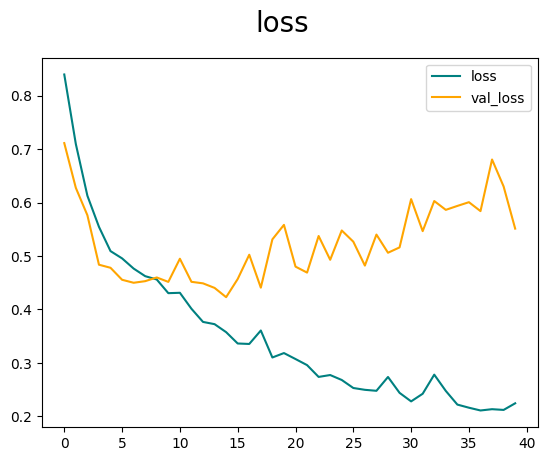

In [349]:
fig = plt.figure()
plt.plot(hist_m2.history['loss'], color = 'teal', label = "loss")
plt.plot(hist_m2.history['val_loss'], color = 'orange', label = "val_loss")
fig.suptitle('loss', fontsize = 20)
plt.legend()
plt.show()

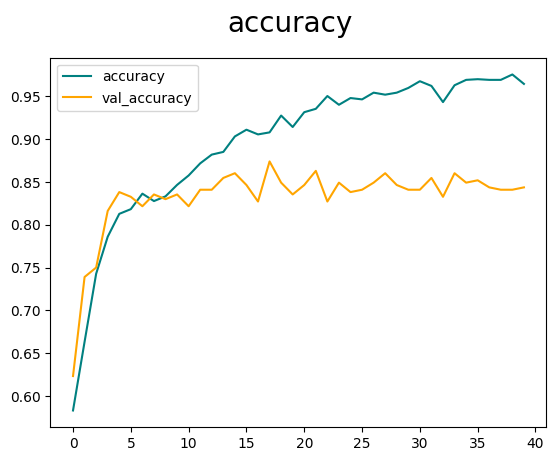

In [350]:
fig = plt.figure()
plt.plot(hist_m2.history['accuracy'], color = 'teal', label = "accuracy")
plt.plot(hist_m2.history['val_accuracy'], color = 'orange', label = "val_accuracy")
fig.suptitle('accuracy', fontsize = 20)
plt.legend()
plt.show()

In [351]:
model_2.save("CNN_model_of_184-1(dandelion/daisy.h5")

In [376]:
def model_MLP_2():
    model = Sequential()
    
    model.add(Flatten(input_shape = (128,128,3)))
    model.add(Dense(128,activation = "ReLU",kernel_regularizer = l2(0.001)))
    model.add(Dropout(0.2))

    model.add(Dense(64,activation = "ReLU",kernel_regularizer = l2(0.001)))
    model.add(Dropout(0.2))

    model.add(Dense(1,activation = "sigmoid"))

    return model
    

In [377]:
MLP_2 = model_MLP_2() 
MLP_2.compile('adam',loss = 'binary_crossentropy',metrics=['accuracy'])

In [378]:
MLP_2.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_29 (Flatten)        (None, 49152)             0         
                                                                 
 dense_71 (Dense)            (None, 128)               6291584   
                                                                 
 dropout_42 (Dropout)        (None, 128)               0         
                                                                 
 dense_72 (Dense)            (None, 64)                8256      
                                                                 
 dropout_43 (Dropout)        (None, 64)                0         
                                                                 
 dense_73 (Dense)            (None, 1)                 65        
                                                                 
Total params: 6,299,905
Trainable params: 6,299,905
N

In [379]:
results_MLP_2 = 'results_MLP_2'

In [380]:
tensorboard_callback_MLP = tf.keras.callbacks.TensorBoard(log_dir=results_MLP_2)

In [381]:
hist_MLP_2 = MLP_2.fit(X,epochs=40,validation_data=V, callbacks = [tensorboard_callback_MLP])

Epoch 1/40
40/40 [==============================] - 1s 15ms/step - loss: 3.5686 - accuracy: 0.5357 - val_loss: 1.0751 - val_accuracy: 0.5907
Epoch 2/40
40/40 [==============================] - 0s 8ms/step - loss: 1.0187 - accuracy: 0.5631 - val_loss: 0.9141 - val_accuracy: 0.5934
Epoch 3/40
40/40 [==============================] - 0s 8ms/step - loss: 0.9030 - accuracy: 0.6016 - val_loss: 0.8688 - val_accuracy: 0.5549
Epoch 4/40
40/40 [==============================] - 0s 8ms/step - loss: 0.8669 - accuracy: 0.5812 - val_loss: 0.8585 - val_accuracy: 0.5522
Epoch 5/40
40/40 [==============================] - 0s 8ms/step - loss: 0.8359 - accuracy: 0.5851 - val_loss: 0.8334 - val_accuracy: 0.5522
Epoch 6/40
40/40 [==============================] - 0s 9ms/step - loss: 0.8097 - accuracy: 0.5851 - val_loss: 0.8125 - val_accuracy: 0.5522
Epoch 7/40
40/40 [==============================] - 0s 9ms/step - loss: 0.8488 - accuracy: 0.5765 - val_loss: 0.8361 - val_accuracy: 0.5522
Epoch 8/40
40/40 [=

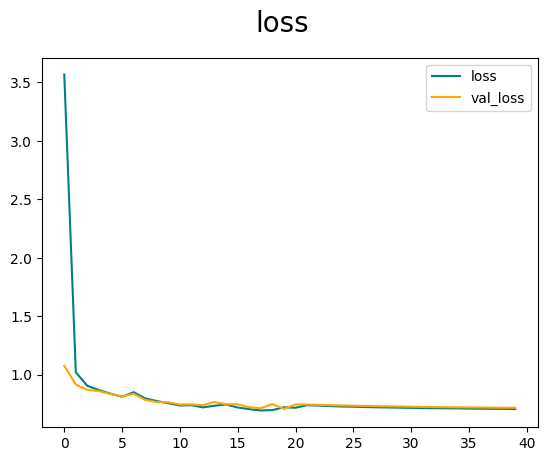

In [388]:
fig = plt.figure()
plt.plot(hist_MLP_2.history['loss'], color = 'teal', label = "loss")
plt.plot(hist_MLP_2.history['val_loss'], color = 'orange', label = "val_loss")
fig.suptitle('loss', fontsize = 20)
plt.legend()
plt.show()

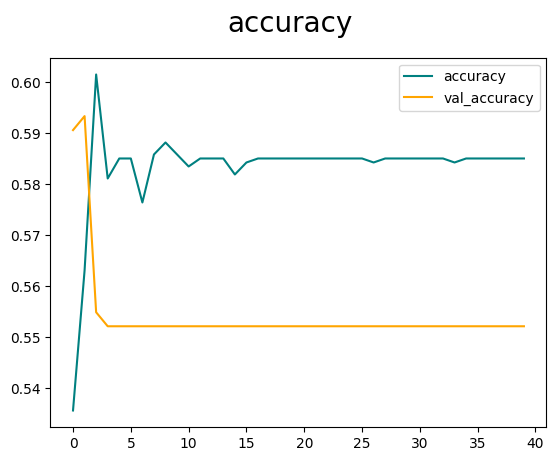

In [389]:
fig = plt.figure()
plt.plot(hist_MLP_2.history['accuracy'], color = 'teal', label = "accuracy")
plt.plot(hist_MLP_2.history['val_accuracy'], color = 'orange', label = "val_accuracy")
fig.suptitle('accuracy', fontsize = 20)
plt.legend()
plt.show()

In [385]:
l = a = c = 0
for batch in T.as_numpy_iterator():
    train_x,y = batch
    loss,accuracy = MLP_2.evaluate(train_x,y)
    l += loss
    a += accuracy
    c += 1

1/1 [==============================] - 0s 23ms/step - loss: 0.6868 - accuracy: 0.6364


In [386]:
print("average loss = ",l / c)

average loss =  0.7059117754300436


In [387]:
print("average accuracy = ",a / c)

average accuracy =  0.580018937587738
